This cell will attempt to download all of the data from the google bucket. Not recommended as the amount of data will require alot of space and time. If running from google colab the storage will be innadequate. 

In [0]:
!gsutil -q -m cp -p -r "gs://gbm_tcga" /tmp

In [0]:
from google.colab import drive
drive.mount('/content/drive')

RUN THIS AND THE NEXT CELL FIRST TO BEGIN THE CREDENTIALING PROCESS. THE GOOGLE DRIVE WILL NOT BE MOUNTABLE OTHERWISE. 

In [0]:
from google.cloud import storage
from google.colab import auth

In [3]:
auth.authenticate_user()
client = storage.Client(project='peak-trilogy-248117')

buckets = client.list_buckets()

print("Buckets in {}:".format(client.project))
for item in buckets:
    print("\t" + item.name)

Buckets in peak-trilogy-248117:
	gbm_tcga


In [4]:
bucket = client.get_bucket('gbm_tcga')

print("Bucket name: {}".format(bucket.name))
print("Bucket location: {}".format(bucket.location))
print("Bucket storage class: {}".format(bucket.storage_class))

Bucket name: gbm_tcga
Bucket location: US
Bucket storage class: MULTI_REGIONAL


This cell will list all of the files that are "T1." If you run may take a while and the amount of output will likely crash the notebook.

In [0]:
blobs = bucket.list_blobs()

print("Blobs in {}:".format(bucket.name))
for item in blobs:
  if "T1" in item.name:
    print("\t" + item.name)


THIS MUST BE RUN AFTER RUNNING THE CELL MARKED WITH RUN THIS FIRST!!!!!!!! The google storage will not be accessed otherwise due to credential issues. I'm not sure why they have to be run in this order or why you have to run both but that is the only way I could get it to work. If it asks you if you want to continue say yes or y. 

In [5]:
!gcloud auth application-default login


The environment variable [GOOGLE_APPLICATION_CREDENTIALS] is set to:
  [/content/adc.json]
Credentials will still be generated to the default location:
  [/content/.config/application_default_credentials.json]
To use these credentials, unset this environment variable before
running your application.

Do you want to continue (Y/n)?  y

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&prompt=select_account&response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform&access_type=offline


Enter verification code: 4/lgFJjPNYFgx0Ghpa67KRZhwsd-eppvdeepM9rjN93a61gxLYb4T33kA

Credentials saved to file: [/content/.config/application_default_credentials.json]

These credentials will be used by any library that requests
Application Default Credential

This cell will download the required packages and dependencies so as to allow you to run gcsfuse. Gcsfuse basically mounts the google cloud storage which allows your system to treat the the storage file as if it were another file on the system.

In [6]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   659  100   659    0     0  25346      0 --:--:-- --:--:-- --:--:-- 26360
OK
26 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 26 not upgraded.
Need to get 4,274 kB of archives.
After this operation, 12.8 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 131289 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.28.1_amd64.deb ...
Unpacking gcsfuse (0.28.1) ...
Setting up gcsfuse (0.28.1) ...


In [0]:
from google.cloud import storage
from google.colab import auth
auth.authenticate_user()

In [8]:
!mkdir /tmp/tcga-gbm
!gcsfuse --implicit-dirs gbm_tcga /tmp/tcga-gbm

Using mount point: /tmp/tcga-gbm
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.


Run this basically as a sanity check. Should list all the files in the bucket. If you get an input output error message, it is likely that your credentials weren't properly established which is probably a result of you having ran the above cells in the wrong order or missed a cell.

In [9]:
!ls /tmp/tcga-gbm

file_names.csv	TCGA-GBM


This cell will search the entire directory for all filepaths containing "T1." Warning, this took several hours when I ran it. Files seem to load quickly but mapping the drive takes a very long time this way.

In [20]:
import os
from tqdm import tqdm

T1_files = []

for root, dirs, files in tqdm(os.walk("/tmp/tcga-gbm")):
    for dir in dirs:
      if "T1" in dir:
        T1_files.append(os.path.join(root, dir))


6251it [3:23:53,  2.00s/it]


I am using the pydicom package for handling the dicom/ .dcm files. Load it into the notebook using this command.

In [23]:
!pip install -U pydicom

     |████████████████████████████████| 7.1MB 4.9MB/s 


This cell creates a interface to allow you to scroll through the stacked dicom images. Scrolling does not work in a notebook. but there should be a sample image from the stack print below.

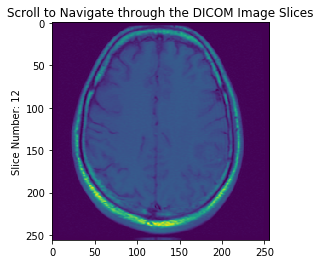

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import pydicom
import pylab as pl
import sys
import matplotlib.path as mplPath

class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('Scroll to Navigate through the DICOM Image Slices')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('Slice Number: %s' % self.ind)
        self.im.axes.figure.canvas.draw()

fig, ax = plt.subplots(1,1)

# load the csv with the correct file paths
files = np.loadtxt('/tmp/tcga-gbm/file_names.csv', dtype=str, delimiter=',')

# set the main directory for the glob command to search over
os.chdir(files[0])

plots = []
frames = []

# search over the file from the defined file path for all dicom images 
for file in glob.glob("*.dcm"):
    ds = pydicom.dcmread(file)
    pix = ds.pixel_array
    frames.append(pix)
    pix = pix*1+(-1024)
    plots.append(pix)

y = np.dstack(plots)

tracker = IndexTracker(ax, y)

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

This is the shape that the sample dicom image stack has.

In [31]:
frames = np.array(frames)
frames.shape

(25, 256, 256)